# VGGNet

## Import Library

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from utils import train_loop,test_loop

## Check MPS Device for GPU

In [2]:
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    print('can use GPU')
    
mps_device = torch.device("mps")

can use GPU


## Load Data

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

training_data = datasets.Flowers102(
    root = '../data/',
    download=True,
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
)

test_data = datasets.Flowers102(
    root='../data/',
    download=True,
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [4]:
training_data

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ../data/
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

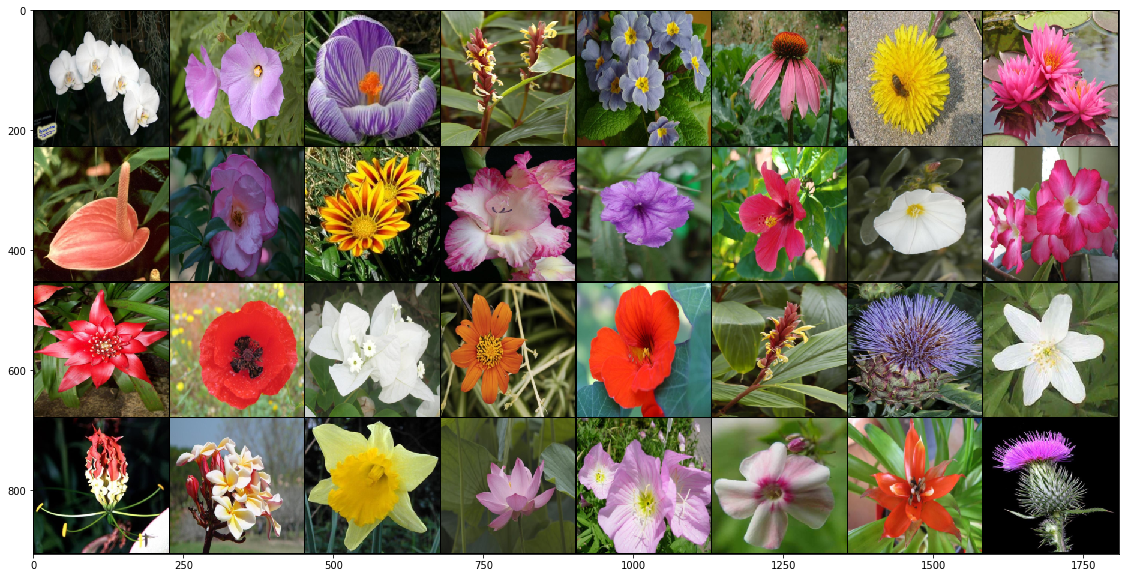

In [5]:
# sample images를 확인
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x_train = []
for batch, (X,y) in enumerate(train_dataloader):
    if batch<1:
        x_train.append(X)
    else:
        break


# tensor를 image로 변경하는 함수를 정의
def show(img):
    # tensor를 numpy array로 변경
    npimg = img.numpy()
    # C*H*W를 H*W*C로 변경
    npimg_tr = npimg.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(npimg_tr, interpolation='nearest')

# images grid를 생성하고 출력
# 총 40개 이미지, 행당 8개 이미지를 출력
x_grid = utils.make_grid(x_train[0][:40], nrow=8, padding=2)

show(x_grid)

## Define Model

In [6]:
import torch
import torch.nn as nn

class VGGNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [8]:
import torchvision.models as model

# non_pretrained_model = VGGNet(num_classes=102)
non_pretrained_model = model.vgg16()
non_pretrained_model = nn.Sequential(
    non_pretrained_model,
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1000,102)
)
summary(non_pretrained_model,(3,224,224),batch_size=32)
non_pretrained_model.to(mps_device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
            Conv2d-3         [32, 64, 224, 224]          36,928
              ReLU-4         [32, 64, 224, 224]               0
         MaxPool2d-5         [32, 64, 112, 112]               0
            Conv2d-6        [32, 128, 112, 112]          73,856
              ReLU-7        [32, 128, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]         147,584
              ReLU-9        [32, 128, 112, 112]               0
        MaxPool2d-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]         295,168
             ReLU-12          [32, 256, 56, 56]               0
           Conv2d-13          [32, 256, 56, 56]         590,080
             ReLU-14          [32, 256,

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

# Use Pretrained VGG-16

In [45]:
import torchvision.models as model

# get pretrained model
vgg_16_model = model.vgg16(weights=model.VGG16_Weights.DEFAULT)
vgg_16_model = nn.Sequential(
    vgg_16_model,
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1000,102)
)
# save weights
# torch.save(vgg_16_model.state_dict(),'vgg_16_weights.pth')

# load weights
# vgg_16_model.load_state_dict(torch.load('vgg_16_weights.pth'))

# move model to GPU
vgg_16_model.to(mps_device)

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

# Train

In [9]:
learning_rate = 0.1
epochs = 80
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(non_pretrained_model.parameters(),lr=learning_rate,momentum=0.9,weight_decay=0.0001)


In [10]:
train_acc, train_loss = [],[]
test_acc, test_loss = [],[]

In [81]:
# torch.save({
#     'epochs':epochs,
#     'model_state_dict' : vgg_16_model.state_dict(),
#     'optimizer_state_dict' : optimizer.state_dict(),
#     'train_acc' : train_acc,
#     'test_acc' : test_acc,
#     'train_loss' : train_loss,
#     'test_loss' : test_loss,
# }, 'vgg_16_model.pt')

In [87]:
# # How to load model checkpoint
# vgg_16_model = model.vgg16()
# vgg_16_model = nn.Sequential(
#     vgg_16_model,
#     nn.ReLU(),
#     nn.Dropout(),
#     nn.Linear(1000,102)
# )
# vgg_16_model.to(mps_device)

# optimizer = torch.optim.SGD(vgg_16_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

checkpoint = torch.load('../SavedTorch/vgg_16_pretrained_model.pt')
# vgg_16_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epochs = checkpoint['epochs']
train_acc = checkpoint['train_acc']
test_acc = checkpoint['test_acc']
train_loss = checkpoint['train_loss']
test_loss = checkpoint['test_loss']


In [11]:
for t in range(epochs):
    print(f'epoch {t+1}')
    tr_acc, tr_loss = train_loop(True,'GPU',train_dataloader,non_pretrained_model,loss_fn,optimizer)
    te_acc, te_loss = test_loop(False, 'GPU',test_dataloader, non_pretrained_model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss[-1])
    test_acc.append(te_acc)
    test_loss.append(te_loss)
    print('train loss: %.6f train acc: %.2f\ntest  loss: %.6f, test acc: %.2f' %(tr_loss[-1],100*tr_acc, te_loss, 100*te_acc))
    print('-'*10)

epoch 1
loss: 4.624389 [    0/ 1020]
loss: 4.643958 [  320/ 1020]
loss: 4.636834 [  640/ 1020]
loss: 4.656195 [  960/ 1020]
train loss: 4.656195 train acc: 0.00
test  loss: 4.625373, test acc: 1.08
----------
epoch 2
loss: 4.622039 [    0/ 1020]
loss: 4.629418 [  320/ 1020]
loss: 4.631822 [  640/ 1020]
loss: 4.653480 [  960/ 1020]
train loss: 4.653480 train acc: 0.00
test  loss: 4.625646, test acc: 1.67
----------
epoch 3
loss: 4.625834 [    0/ 1020]
loss: 4.629313 [  320/ 1020]
loss: 4.647138 [  640/ 1020]
loss: 4.643517 [  960/ 1020]
train loss: 4.643517 train acc: 0.00
test  loss: 4.625425, test acc: 0.98
----------
epoch 4
loss: 4.623357 [    0/ 1020]
loss: 4.630846 [  320/ 1020]
loss: 4.640020 [  640/ 1020]
loss: 4.642844 [  960/ 1020]
train loss: 4.642844 train acc: 0.00
test  loss: 4.624890, test acc: 0.98
----------
epoch 5
loss: 4.630199 [    0/ 1020]
loss: 4.623298 [  320/ 1020]
loss: 4.645898 [  640/ 1020]
loss: 4.645504 [  960/ 1020]
train loss: 4.645504 train acc: 0.00
tes

In [24]:
# torch.save({
#     'epochs':epochs,
#     'model_state_dict' : vgg_16_model.state_dict(),
#     'optimizer_state_dict' : optimizer.state_dict(),
#     'train_acc' : train_acc,
#     'test_acc' : test_acc,
#     'train_loss' : train_loss,
#     'test_loss' : test_loss,
# }, 'vgg_16_model.pt')

## Result of Flowers102 Dataset

### Begin with Pretrained Weight

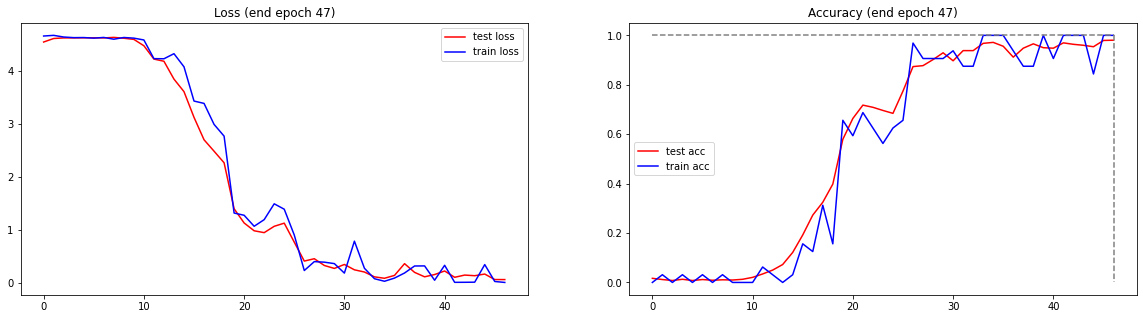

In [49]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.set_title('Loss (end epoch 47)')
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.set_title('Accuracy (end epoch 47)')
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.plot([0,46],[1,1],'--',color='gray')
ax.plot([46,46],[1,0],'--',color='gray')
ax.legend()

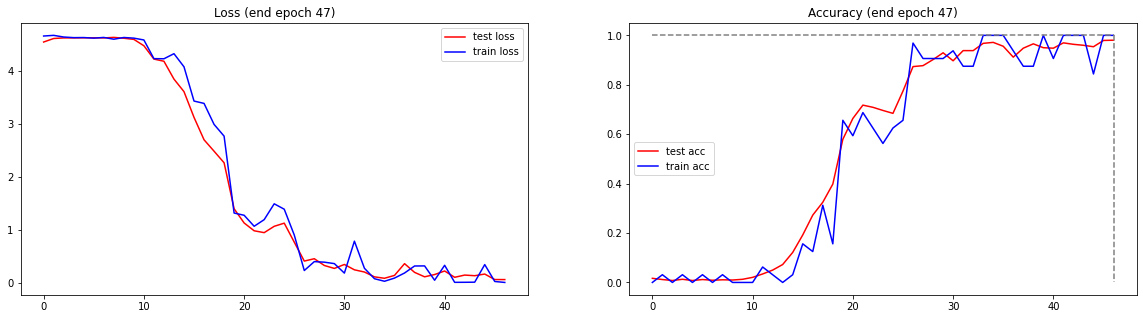

In [88]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.set_title('Loss (end epoch 47)')
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.set_title('Accuracy (end epoch 47)')
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.plot([0,46],[1,1],'--',color='gray')
ax.plot([46,46],[1,0],'--',color='gray')
ax.legend()

### Begin with non-Pretrained Weights

### SGD

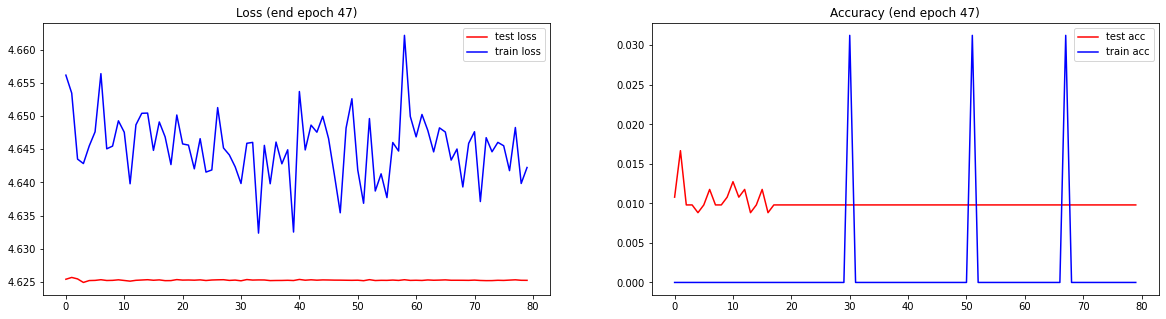

In [12]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.set_title('Loss (end epoch 47)')
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.set_title('Accuracy (end epoch 47)')
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.legend()

### Adam

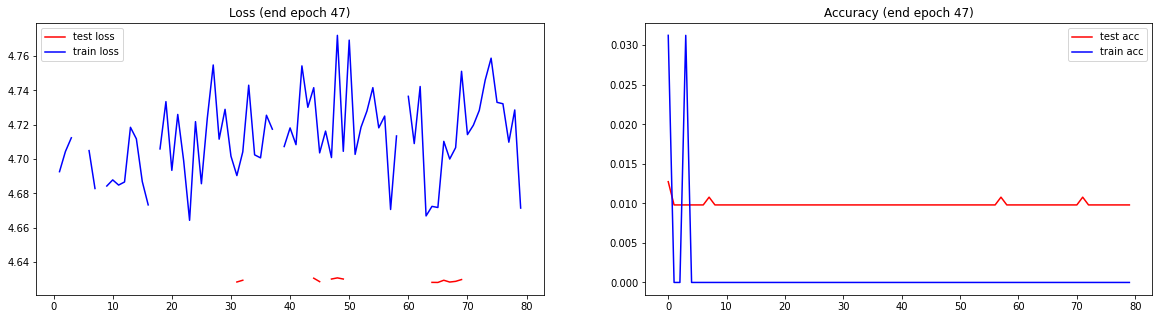

In [86]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.set_title('Loss (end epoch 47)')
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.set_title('Accuracy (end epoch 47)')
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.legend()